# Introduction and Business Problem

In this notebook, I will be performing data analysis and linear regression on a data set from King's County. The data is home sale prices and relevant home information. The goal of the analysis is to build a linear regression model that explains the sale prices for homes in King's County using various attributes. The stakeholder for this business problem is an independent real estate investor, who buys homes and invests in them to sell them for a netted profit.

# Data Exploration

In [1]:
# import packages

import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
#plt.style.use('seaborn')

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import data
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
# get data dimensions
df.shape

(21597, 21)

In [4]:
# observe types of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

From the above descriptions, the data is a set of 21,597 observed home sale prices, and 20 attributes of the sale (19 if you disregard the sale ID). The data types are either numeric or descriptive - those that are not numeric and deemed relevant will have to be transformed to categorical variables.

# Data Preparation

Though we already know that the data will have to be pre-processed for inclusion in the linear model, looking at potential missing values is a good place to start because how we decide to deal with missing values will determine in part how we go about processing the data. 

In [5]:
# count missing values
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

From this table, we can see that missing values are confined to three variables: waterfront, view, and renovation year. Because these are all intuitively important variables, we should not deal with the missing values by simply not including these variables as important predictors. Moreover, because the number of missing values for waterfront and renovation year are sizeable, we should not necessary simply exclude these observations - especially as the fact of missingness might have some explanatory value. For the missing values of view, however, we will go ahead and exclude those observations because the number of missing values is relatively small compared to the size of the overall dataset.

In [6]:
# drop rows with missing value of 'view' predictor
df = df.dropna(subset=['view'])
df.shape

(21534, 21)

## Numerical Data

Now we need to go through the dataset and examine the relationships between each independent variable and the dependent variable, sale price. Before we do this however, we can begin by looking en masse at the relationship between just the numeric variables and sale price.

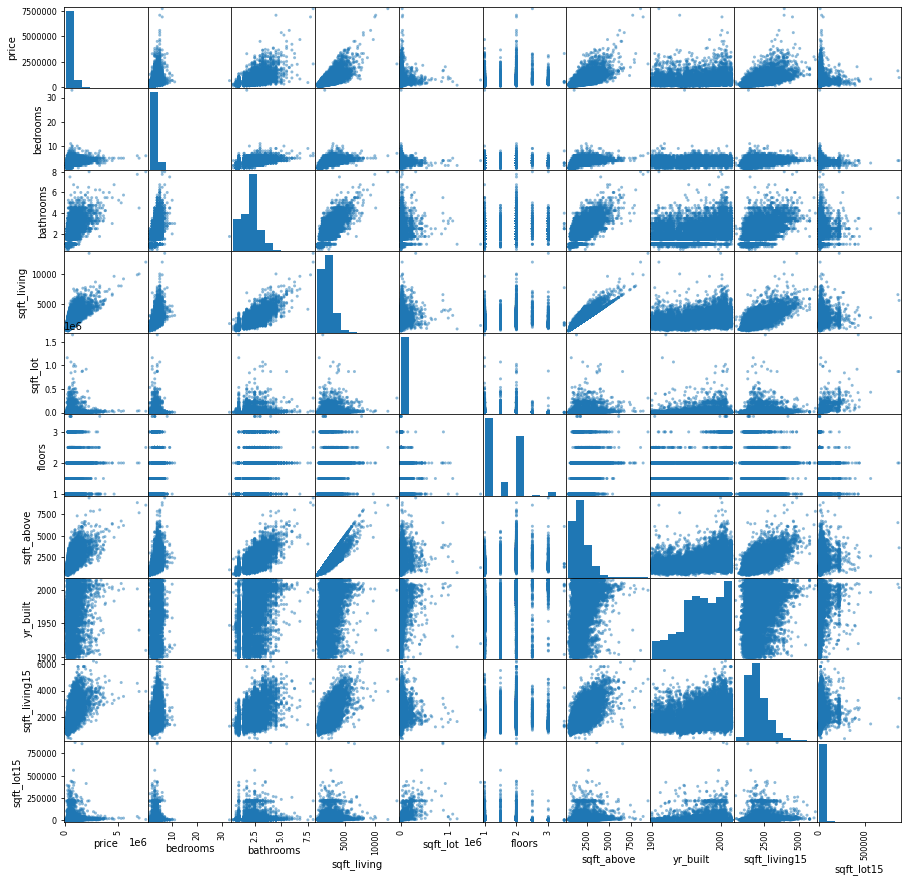

In [7]:
# subset numeric variables to observe direction relationship to sale price
numeric = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement',
           'yr_built','sqft_living15','sqft_lot15']
pd.plotting.scatter_matrix(df[numeric], figsize=(15,15));

The above plot is useful for a few considerations that can provide a strong start for data processing and analysis. Importantly, this is just numerical predictors - we have not even begun to look at the explanatory value that categorical variables might provide. But the scatter plot does have some immediate takeaways:

1. The price variable itself does not appear to be normally distributed (and neither do some predictors) - before we even beginning evaluating models, we might have to consider either transforming the price variable or dropping some outlying observations.

2. While most of the variables in the plot show some (largely positive relationships), there are a couple at first glance that clearly do not - floors and year built. We will probably not consider including these variables in an early version of the model, if at all.

3. The square foot of living space and square foot of space above the basement variables seem to have a very strong linear relationship - it looks for some observations that they are almost identical. This is a strong indication of multicollinearity, and going forward we will probably only consider including one of these variables in the model, if at all.

4. The differing scales of the independent variables suggest that data normalization or scaling might be useful. Though this will likely improve the overall reliability of the model, it means that train/test splitting might be a better approach for model validation, because performing so many transformations in a cross-validation context will be too computationally intensive.

Additionally, it is important to note that note of the geographic data - zip code, latitude, or longitude - was considered numeric in this context. Though location probably does have some bearing on home price, the problem with treating this data as numeric is that it is not necessarily linear with home price, i.e. areas with higher zip codes may not have higher sale prices, even if it does impact the price in some other way (better school district, for example). Therefore, we will have to consider how else it might make sense to include locationd data in the model.

Now we can go through some of the variables individually and make observations or decide on transformations that might be useful for creating a strong model from the outset. In order to track any changes or transformations we make to variables, we should create a new dataframe to store those updates.

In [8]:
# copy dataframe to hold updated variables
df_new = df.copy()
df_new.shape

(21534, 21)

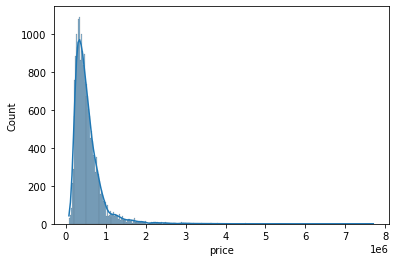

In [9]:
# histogram of price (DEPENDENT) variable
sns.histplot(df['price'],kde=True);

The histogram of price, the dependent variable, suggests that it would be a good candidate for log transformation - as the number of homes with higher sale prices drops off considerably with price itself.

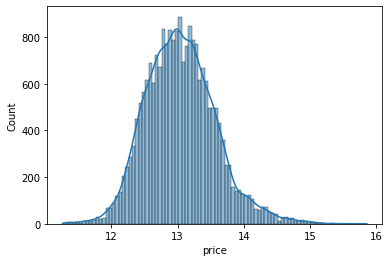

In [10]:
# histogram of price (DEPENDENT) variable with log transformation
sns.histplot(np.log(df['price']),kde=True);

Though the price variable with the log transformation is not perfectly normally distributed, it is visibly much closer to that with the data having been logged transformed. Before proceeding, it makes sense to run a single model as a baseline example. This way, whenever we are questioning if a certain transformation or addition will positively alter the model, we have something to refer to. 

In [11]:
# create new log_price column
df_new['log_price'] = np.log(df_new['price'])
df_new.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,12.309982
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,13.195614
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,12.100712
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,13.311329
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,13.142166


In [12]:
# examine number of bedrooms
df['bedrooms'].describe()

count    21534.000000
mean         3.373038
std          0.926410
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

In [13]:
# max number of bedrooms looks like an outlier - examine table of values for more context
df['bedrooms'].value_counts().sort_index()

1      196
2     2754
3     9791
4     6865
5     1596
6      270
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [14]:
# since 33 bedrooms is an obvious outlier, we will remove that observation from the data set
df_new = df_new[df_new['bedrooms'] <= 11]
df_new.shape

(21533, 22)

count    21534.000000
mean         2.115712
std          0.768602
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64


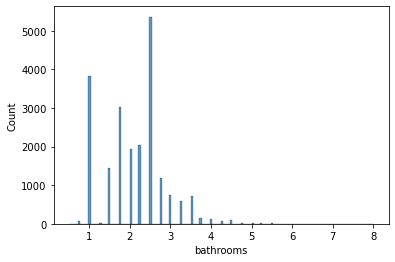

In [15]:
# repeat above for bathrooms
print(df['bathrooms'].describe())
sns.histplot(df['bathrooms']);

Even though the bathrooms data is not normally distributed, in absolute terms, it does not appear that the distribution of bathrooms is so large, and it is not clear what kind of transformation should be performed on the data to improve it.

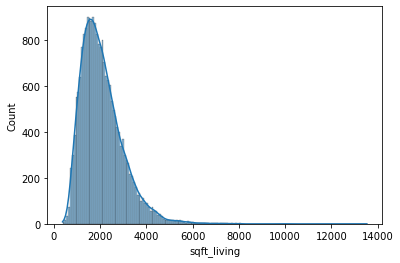

In [16]:
# histogram of square foot of living
sns.histplot(df['sqft_living'],kde=True);

Here we see a similar distribution to price - a log transformation should help the data here appear more normal.

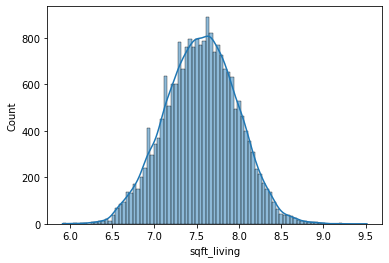

In [17]:
# histogram of log transformed square foot of living 
sns.histplot(np.log(df['sqft_living']),kde=True);

Though there is still the appearance of a small upper tail here, the log transformation clearly suits the original distribution of living space square foot. We can replace the data, and since we know that the data for square footage above ground is very similarly distributed, we will go ahead and replace that data as well.

In [18]:
# create new log transformation columns for sqft_living and sqft_above
df_new['log_sqft_living'] = np.log(df_new['sqft_living'])
df_new['log_sqft_above'] = np.log(df_new['sqft_above'])
df_new.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_living,log_sqft_above
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,1955,0.0,98178,47.5112,-122.257,1340,5650,12.309982,7.073270,7.073270
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,13.195614,7.851661,7.682482
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,NaN,98028,47.7379,-122.233,2720,8062,12.100712,6.646391,6.646391
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,0.0,98136,47.5208,-122.393,1360,5000,13.311329,7.580700,6.956545
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,0.0,98074,47.6168,-122.045,1800,7503,13.142166,7.426549,7.426549


From the scatter plots above, it seems that both square footage of the lot and number of floors have very weak, if any, linear relationships with sale price. For that reason, we will disregard those for now, and perhaps consider re-visiting later. The same is true of year built. There is likely some value in looking more closely at year of renovation, but that will be looked at in the context of missing values first.

The bit of the data we should look at in this context - though it is not numeric - is geographic data. As per above, the geographic data as determined by zip code is likely valuable, because of what the zip code represents - school district, taxes, funding, even reputation.

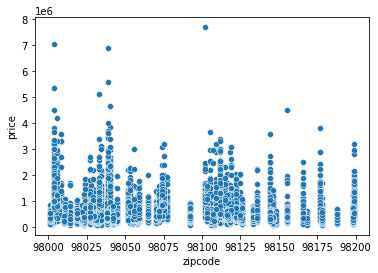

In [19]:
# plot price as a function of zip code
sns.scatterplot(df['zipcode'],df['price']);

As we can see from the scatterplot, some zip codes are clearly associated with higher sale prices than others. However, there is no numerical relationship between the actual zip code and the sale price. For this reason, we should consider looking at the latitude and longitude data provided, which might prove more useful.

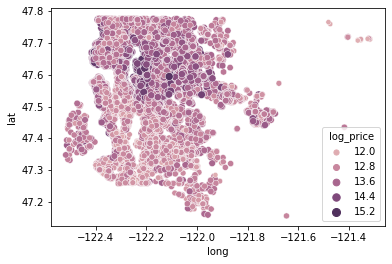

In [20]:
# plot latitude vs longitude - this map is a representative graphic of sale price
sns.scatterplot(df_new['long'],df_new['lat'],hue=df_new['log_price'],size=df_new['log_price']);

Since we are looking at latitude vs longitude, we have an actual geographic depiction of the data points. And using coloring by sale price (log transformed, to make the scale more visible) we see that towards the center of the plot there is a higher concentration of darker circles, representing higher sale prices. Since the data points are not evenly distributed in space, we will have to make a somewhat arbitrary division of the data points.

In [21]:
# divide points as above or below midpoint of latitude
mid_lat = np.min(df_new['lat'])+(np.max(df_new['lat']) - np.min(df_new['lat']))/2
df_new['high_lat'] = df_new['lat'].apply(lambda x: 1 if x >= mid_lat else 0)
df_new.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_living,log_sqft_above,high_lat
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,0.0,98178,47.5112,-122.257,1340,5650,12.309982,7.073270,7.073270,1
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1991.0,98125,47.7210,-122.319,1690,7639,13.195614,7.851661,7.682482,1
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,NaN,98028,47.7379,-122.233,2720,8062,12.100712,6.646391,6.646391,1
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,0.0,98136,47.5208,-122.393,1360,5000,13.311329,7.580700,6.956545,1
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,98074,47.6168,-122.045,1800,7503,13.142166,7.426549,7.426549,1


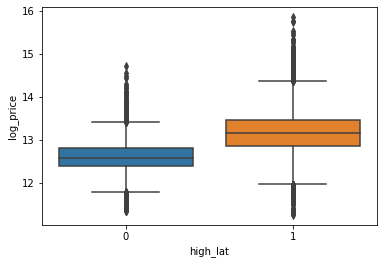

In [22]:
# plot boxplot of latitude distinction
sns.boxplot(df_new['high_lat'],df_new['log_price']);

From the boxplot of latitudes - either above the midpoint or below the midpoint - we see latitude above the midpoint indeed has a higher log sale price. However, as expected from the scatter plot, there is a lot of noise in the latitude distributions themselves, so it remains to be seen how useful this variable could be.

Related to geographic area of the house is the information provided about neighboring houses. Specifically, the data set provides the total square footage of living area and lot area for the nearest 15 properties. From the scatter plot above, it appears that the living area of the nearest 15 houses is more strongly linearly related to sale price. Let's consider it more closely.

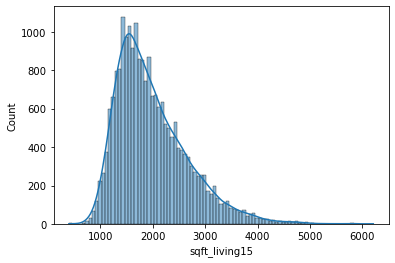

In [24]:
# histogram of square foot of nearest 15 homes
sns.histplot(df['sqft_living15'],kde=True);

As anticipated, this has a similar distribution to the square footage of interior space of single homes - therefore, we will perform the same log transform and consider that this predictor may introduce some multicollinearity should we choose to use it, however it likely does capture some of the necessary geographic data that we will omit by not making use of zip code.

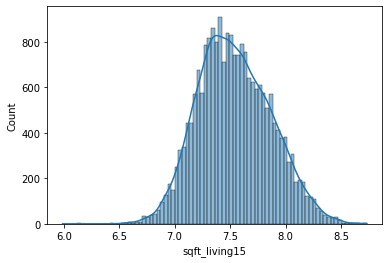

In [25]:
# histogram of log of square foot of nearest 15 homes
sns.histplot(np.log(df['sqft_living15']),kde=True);

In [26]:
# add transformed variable to new dataframe
df_new['log_sqft_living15'] = np.log(df_new['sqft_living15'])
df_new.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_living,log_sqft_above,high_lat,log_sqft_living15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,98178,47.5112,-122.257,1340,5650,12.309982,7.073270,7.073270,1,7.200425
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,98125,47.7210,-122.319,1690,7639,13.195614,7.851661,7.682482,1,7.432484
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,98028,47.7379,-122.233,2720,8062,12.100712,6.646391,6.646391,1,7.908387
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,98136,47.5208,-122.393,1360,5000,13.311329,7.580700,6.956545,1,7.215240
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,98074,47.6168,-122.045,1800,7503,13.142166,7.426549,7.426549,1,7.495542


## Categorical Variables

Now that numerical variables have been dealt with, we can switch focus to categorical variables, including those with potentially missing data. The first one we will consider is date. To capture the explanatory value within the date variable, we can consider the impact of date by seasons - another way to do this would be looking by year, however that would create an additional 11 variables as opposed to an additional 3.

In [28]:
# extract month from date column
df_new['month'] = df_new['date'].apply(lambda x: x.split('/')[0]).astype(int)
df_new.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,log_price,log_sqft_living,log_sqft_above,high_lat,log_sqft_living15,month
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,47.5112,-122.257,1340,5650,12.309982,7.073270,7.073270,1,7.200425,10
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,47.7210,-122.319,1690,7639,13.195614,7.851661,7.682482,1,7.432484,12
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,47.7379,-122.233,2720,8062,12.100712,6.646391,6.646391,1,7.908387,2
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,47.5208,-122.393,1360,5000,13.311329,7.580700,6.956545,1,7.215240,12
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,47.6168,-122.045,1800,7503,13.142166,7.426549,7.426549,1,7.495542,2


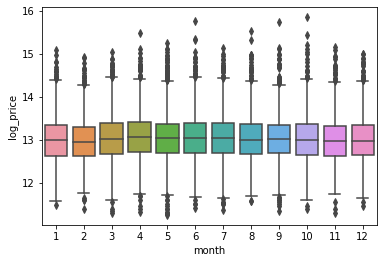

In [29]:
# boxplot of sale price by sale month
sns.boxplot(df_new['month'],df_new['log_price']);

From the boxplot of log sale price by month of sale, it appears that the median sale price does not fluctuate much by month of sale.

In [30]:
# look at values for waterfront variable
df_new['waterfront'].value_counts()

NO     19018
YES      145
Name: waterfront, dtype: int64

The values that we have for waterfront are 'yes' and 'no'; however we know we also have missing values. From a modeling perspective, the missing values might be informational in themselves, so we should account for them with their own category, which we will replace with the string 'UNKWOWN.'

In [31]:
# replace missing values with 'UNKNOWN'
df_new['waterfront'] = df_new['waterfront'].fillna('UNKNOWN')

In [32]:
# check new valus of waterfront variable
df_new['waterfront'].value_counts()

NO         19018
UNKNOWN     2370
YES          145
Name: waterfront, dtype: int64

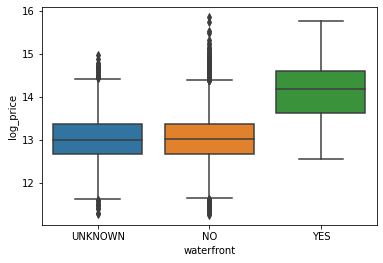

In [33]:
# boxplot of price vs waterfront
sns.boxplot(df_new['waterfront'],df_new['log_price']);

Looking at the previously missing waterfront values, the data suggests that values for waterfront that were missing are actually likely to be 'NO', as they have very similar distributions. However, without any separate knowledge, we have to treat 'UNKNOWN' as its own variable - there is a chance, however, that it will not provide any additional predictive value. From the boxplot, it appears that waterfront properties do in fact yield higher average sale prices.

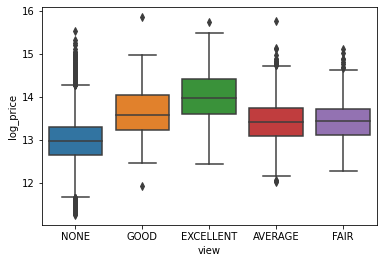

In [34]:
# boxplot of price vs view
sns.boxplot(df_new['view'],df_new['log_price']);

Looking at log price based on view, it does seeem that there is some differentiation among the classes and also in a way that makes sense, i.e. excellent view yields the best average sales price and no view yields the worst.

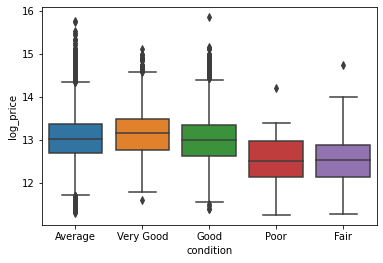

In [35]:
# boxplot of price vs condition
sns.boxplot(df_new['condition'],df_new['log_price']);

As for differentiation based on condition, it is less obvious here than when considering view, for example, but it may eventually prove to be a useful indicator variable.

In [36]:
# table of values for square footage of basement
df['sqft_basement'].value_counts()

0.0       12798
?           452
600.0       216
500.0       209
700.0       207
          ...  
506.0         1
508.0         1
2310.0        1
172.0         1
143.0         1
Name: sqft_basement, Length: 302, dtype: int64

When we look at the table of values for basement square footage, which is listed as 'object' in the description, we see the reason for this - what should actually be a numerical value has missing values in the form of '?,' which we can interpret either as missing or perhaps deemed incorrect. Since some kind of imputation would make the most sense to deal with these values, for the moment I think it probably makes more sense to just leave out this predictor - since we should not rely on imputation unless it is highly necessary, and we have enough other predictors - total square footage, square footage of living area, square footage above ground - that should compensate for the explanatory value of this variable.

In [37]:
# table of values for year renovated
df['yr_renovated'].value_counts()

0.0       16961
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [38]:
test = df[df['yr_renovated'] >= 2000.0]

For the year renovated variable, we run into two issues - the first being a high-value count for '0.0,' which suggests a lack of renovation, in addition to the missing values we noted earlier. Again, for the moment I think this variable is probably best left out, at least for initial analysis. The reason for this is that, renovation year should most likely be considered in comparison to the year the house was built, and moreover, if a house was renovated, the value should in theory be captured by the 'condition' variable, assuming the renovation was value-adding. While there is probably more to dig into with this predictor, for the moment we will not consider it.

## Linear Regression Model

Now that we have gone through all of the data provided, we can start the process of iteratively constructing linear models. To do this, I will start with building a simple linear model with one independent variable, and continue to add variables with the purpose of strengthening the predictive power of the model. 

In doing so, there is the need to balance increasing the inferential power of the model while considering that some statistically important variables might be meaningless for the individual investor. For example, the lot size, should it be inferentially important, is not something the individual investor can likely modify - so when adding new variables to the model, it will be important to focus on independent variables that the average real estate investor could actually change.

To this end, independent variables that would be both useful for individual investors and inferential purposes are:
* square footage of living area
* number of bedrooms
* number of bathrooms
* number of floors
* condition
* time since last renovation, if any
* timing of sale

Independent variables that are unlikely to be useful for an individual investor but, based on analysis above as well as intuition, are likely to be useful for explanatory purposes, are:
* square footage of the lot
* waterfront property
* property view
* square footage of basement
* location

In [ ]:
# import packages for linear models
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [33]:
# MODEL 1: log_price ~ log_sqft_living
formula = 'price ~ sqft_living' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 2.087e+04
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:06:46   Log-Likelihood:            -2.9912e+05
No. Observations:               21534   AIC:                         5.982e+05
Df Residuals:                   21532   BIC:                         5.983e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.215e+04   4404.521     -9.570      0.000   -5.08e+04   -3.35e+04
sqft_living   279.9321      1.938    144.473      0.000     276.134     283.730
==============================================================================
Omnibus:                    14582.265   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           516142.289
Skew:                           2.781   Prob(JB):                         0.00
Kurtosis:                      26.331   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
# MODEL 2: log_price ~ log_sqft_living + bedrooms + bathrooms
formula = 'price ~ sqft_living + bedrooms + bathrooms + high_lat + view + condition' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     3121.
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:16:15   Log-Likelihood:            -2.9556e+05
No. Observations:               21534   AIC:                         5.912e+05
Df Residuals:                   21521   BIC:                         5.913e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  -3e+04   1.01e+04     -2.964      0.003   -4.98e+04   -1.02e+04
view[T.EXCELLENT]       4.678e+05   1.44e+04     32.471      0.000     4.4e+05    4.96e+05
view[T.FAIR]            3.596e+04   1.41e+04      2.547      0.011    8283.708    6.36e+04
view[T.GOOD]            9.577e+04   1.22e+04      7.874      0.000    7.19e+04     1.2e+05
view[T.NONE]           -9.968e+04   7428.845    -13.418      0.000   -1.14e+05   -8.51e+04
condition[T.Fair]         60.9272   1.71e+04      0.004      0.997   -3.35e+04    3.37e+04
condition[T.Good]       4.792e+04   3579.065     13.390      0.000    4.09e+04    5.49e+04
condition[T.Poor]       -2.36e+04   4.12e+04     -0.573      0.567   -1.04e+05    5.71e+04
condition[T.Very Good]  9.071e+04   5726.639     15.840      0.000    7.95e+04    1.02e+05
sqft_living              263.7001      2.754     95.766      0.000     258.303     269.097
bedrooms               -4.452e+04   2040.458    -21.818      0.000   -4.85e+04   -4.05e+04
bathrooms               2.512e+04   3083.583      8.145      0.000    1.91e+04    3.12e+04
high_lat                2.373e+05   3531.373     67.184      0.000     2.3e+05    2.44e+05
==============================================================================
Omnibus:                    16275.404   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1005422.456
Skew:                           3.090   Prob(JB):                         0.00
Kurtosis:                      35.899   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# MODEL 2: log_price ~ log_sqft_living + bedrooms + bathrooms
formula = 'log_price ~ sqft_living + bathrooms + high_lat + view + condition' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     4238.
Date:                Tue, 06 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:55:10   Log-Likelihood:                -4323.4
No. Observations:               21534   AIC:                             8671.
Df Residuals:                   21522   BIC:                             8767.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11.9766      0.013    945.920      0.000      11.952      12.001
view[T.EXCELLENT]          0.3268      0.019     16.978      0.000       0.289       0.365
view[T.FAIR]               0.0412      0.019      2.180      0.029       0.004       0.078
view[T.GOOD]               0.0897      0.016      5.512      0.000       0.058       0.122
view[T.NONE]              -0.1651      0.010    -16.632      0.000      -0.185      -0.146
condition[T.Fair]         -0.1900      0.023     -8.289      0.000      -0.235      -0.145
condition[T.Good]          0.0670      0.005     14.041      0.000       0.058       0.076
condition[T.Poor]         -0.2537      0.055     -4.605      0.000      -0.362      -0.146
condition[T.Very Good]     0.1208      0.008     15.809      0.000       0.106       0.136
sqft_living                0.0003   3.45e-06     91.737      0.000       0.000       0.000
bathrooms                  0.0711      0.004     17.435      0.000       0.063       0.079
high_lat                   0.5017      0.005    106.354      0.000       0.492       0.511
==============================================================================
Omnibus:                      758.497   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2020.474
Skew:                          -0.130   Prob(JB):                         0.00
Kurtosis:                       4.478   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
# MODEL 2: log_price ~ log_sqft_living + bedrooms + bathrooms
formula = 'log_price ~ sqft_living + bathrooms + high_lat + view + condition + C(month)' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     2141.
Date:                Fri, 09 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:39:15   Log-Likelihood:                -4243.8
No. Observations:               21534   AIC:                             8534.
Df Residuals:                   21511   BIC:                             8717.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11.9449      0.016    764.973      0.000      11.914      11.975
view[T.EXCELLENT]          0.3272      0.019     17.055      0.000       0.290       0.365
view[T.FAIR]               0.0417      0.019      2.214      0.027       0.005       0.079
view[T.GOOD]               0.0903      0.016      5.570      0.000       0.059       0.122
view[T.NONE]              -0.1640      0.010    -16.578      0.000      -0.183      -0.145
condition[T.Fair]         -0.1894      0.023     -8.284      0.000      -0.234      -0.145
condition[T.Good]          0.0678      0.005     14.253      0.000       0.058       0.077
condition[T.Poor]         -0.2478      0.055     -4.514      0.000      -0.355      -0.140
condition[T.Very Good]     0.1241      0.008     16.285      0.000       0.109       0.139
C(month)[T.2]              0.0225      0.013      1.781      0.075      -0.002       0.047
C(month)[T.3]              0.0704      0.012      6.037      0.000       0.048       0.093
C(month)[T.4]              0.0842      0.011      7.418      0.000       0.062       0.106
C(month)[T.5]              0.0347      0.011      3.098      0.002       0.013       0.057
C(month)[T.6]              0.0252      0.011      2.213      0.027       0.003       0.048
C(month)[T.7]              0.0170      0.011      1.495      0.135      -0.005       0.039
C(month)[T.8]              0.0167      0.012      1.441      0.150      -0.006       0.039
C(month)[T.9]              0.0119      0.012      1.007      0.314      -0.011       0.035
C(month)[T.10]             0.0109      0.012      0.938      0.348      -0.012       0.034
C(month)[T.11]             0.0120      0.012      0.977      0.329      -0.012       0.036
C(month)[T.12]             0.0054      0.012      0.439      0.661      -0.019       0.029
sqft_living                0.0003   3.44e-06     92.148      0.000       0.000       0.000
bathrooms                  0.0713      0.004     17.554      0.000       0.063       0.079
high_lat                   0.5017      0.005    106.638      0.000       0.493       0.511
==============================================================================
Omnibus:                      779.066   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2097.925
Skew:                          -0.135   Prob(JB):                         0.00
Kurtosis:                       4.505   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
# MODEL 2: log_price ~ log_sqft_living + bedrooms + bathrooms
formula = 'log_price ~ sqft_living + bathrooms + high_lat + view + condition + floors' 
model = ols(formula=formula, data=df_new).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     3958.
Date:                Fri, 09 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:41:53   Log-Likelihood:                -4185.5
No. Observations:               21534   AIC:                             8397.
Df Residuals:                   21521   BIC:                             8501.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11.9193      0.013    913.886      0.000      11.894      11.945
view[T.EXCELLENT]          0.3272      0.019     17.106      0.000       0.290       0.365
view[T.FAIR]               0.0479      0.019      2.549      0.011       0.011       0.085
view[T.GOOD]               0.0914      0.016      5.656      0.000       0.060       0.123
view[T.NONE]              -0.1712      0.010    -17.347      0.000      -0.191      -0.152
condition[T.Fair]         -0.1742      0.023     -7.641      0.000      -0.219      -0.130
condition[T.Good]          0.0852      0.005     17.520      0.000       0.076       0.095
condition[T.Poor]         -0.2436      0.055     -4.450      0.000      -0.351      -0.136
condition[T.Very Good]     0.1416      0.008     18.412      0.000       0.127       0.157
sqft_living                0.0003   3.43e-06     92.635      0.000       0.000       0.000
bathrooms                  0.0455      0.004     10.510      0.000       0.037       0.054
high_lat                   0.4973      0.005    105.904      0.000       0.488       0.506
floors                     0.0744      0.004     16.660      0.000       0.066       0.083
==============================================================================
Omnibus:                      722.801   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1946.159
Skew:                          -0.099   Prob(JB):                         0.00
Kurtosis:                       4.459   Cond. No.                     6.21e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For the basic linear model, which is price as a function of square footage of living area, we see that the R^2 of the model is 0.492. We can interpret this as saying, the square footage of living areas of home explains 49.2% of the variability in home sale prices - this is probably not going to yield a whole lot of predictive value (i.e. what explains the other 50%?) but it is a good starting place for a single-variable model. Going forward, we can add more variables to see if we can improve predictive value. For example, adding number of bedrooms and bathrooms is probably a good place to start.

In [63]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
fig = sm.graphics.plot_regress_exog(model)
plt.show()

TypeError: plot_regress_exog() missing 1 required positional argument: 'exog_idx'

<Figure size 864x864 with 0 Axes>